## Importing all required Modules

In [1]:
#all imports
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer
import zipfile, os, warnings, joblib, import_ipynb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,LabelBinarizer,StandardScaler
in_dict=joblib.load("in_dict")
warnings.filterwarnings('ignore')

## Reading Csv File

In [2]:
# ref: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

# reading csv files and get csv files path
train_dataframe = pd.read_csv("train_users.csv")     
Target_Labels = train_dataframe['country_destination']
test_path, sess_path='test_users.csv', 'sessions.csv'

## Train and Test Split

In [3]:
# ref: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

# perform train test split
import warnings
warnings.filterwarnings('ignore')
X_train, X_test, y_train, y_test = train_test_split(train_dataframe, LabelEncoder().fit_transform(Target_Labels),test_size=0.3,
                                                    random_state=0,stratify=LabelEncoder().fit_transform(Target_Labels))
# printing size of train test data
print('X_train and y_train : ({},{})'.format(X_train.shape, y_train.shape))
print('X_test  and y_test  : ({},{})'.format(X_test.shape, y_test.shape))

X_train and y_train : ((149415, 16),(149415,))
X_test  and y_test  : ((64036, 16),(64036,))


## Data Preparation and Feature extraction

In [4]:
# Data Preparation
from Data_Preparation_Airbnb_New_User_Booking import Data_Preparation
print("{0}\nTrain_Data_Preparation".format("-"*48))
Data_path={"train":X_train,"test":test_path,"session":sess_path}
X_train_Prepared_Data, y_train_target_labels=Data_Preparation(Data_path,True)

print("{0}\nTest_Data_Preparation".format("-"*48))
Data_path={"train":X_test,"test":test_path,"session":sess_path}
X_test_Prepared_Data, y_test_target_labels=Data_Preparation(Data_path,True)
print("-"*48)

importing Jupyter notebook from Data_Preparation_Airbnb_New_User_Booking.ipynb
------------------------------------------------
Train_Data_Preparation
Data_Preparation Module
1.Reading Csv Files    .. .. .. >>> |Done| <1/5>
2.Preprocessing Data   .. .. .. >>> |Done| <2/5>
3.Extracting Features  .. .. .. >>> |Done| <3/5>
4.Formatting Data      .. .. .. >>> |Done| <4/5>
5.Returning Final Data .. .. .. >>> |Done| <5/5>
------------------------------------------------
Test_Data_Preparation
Data_Preparation Module
1.Reading Csv Files    .. .. .. >>> |Done| <1/5>
2.Preprocessing Data   .. .. .. >>> |Done| <2/5>
3.Extracting Features  .. .. .. >>> |Done| <3/5>
4.Formatting Data      .. .. .. >>> |Done| <4/5>
5.Returning Final Data .. .. .. >>> |Done| <5/5>
------------------------------------------------


## Feature Selection

In [1]:
# Feature Selection
print("Train_Feature_Selection")
from Data_Preparation_Airbnb_New_User_Booking import Feature_Selection
X_train_data,Selected_Features=Feature_Selection(X_train_Prepared_Data, y_train_target_labels, Keep_percent=0.7, kag_sub=False, Rerun=False)

print("{0}\nTest_Feature_Selection".format("-"*68))
X_test_Data, _ =Feature_Selection(X_test_Prepared_Data, y_test_target_labels, Keep_percent=0.7, kag_sub=False, Rerun=False)
print("-"*68)

Train_Feature_Selection:
1.Performing Train Validation split on Data .. .. .. >>> |Done| <1/3>
2.Training Xgboost for Feature Importance   .. .. .. >>> |Done| <2/3>
3.Returning Selected Features               .. .. .. >>> |Done| <3/3>
Selected 462 Important Features from 661 Features
--------------------------------------------------------------------
Test_Feature_Selection:
1.Performing Train Validation split on Data .. .. .. >>> |Done| <1/3>
2.Training Xgboost for Feature Importance   .. .. .. >>> |Done| <2/3>
3.Returning Selected Features               .. .. .. >>> |Done| <3/3>
Selected 462 Important Features from 661 Features
--------------------------------------------------------------------


## Data Standardization

In [10]:
# ref: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

# Data Standardization
std_scale = StandardScaler().fit(X_train_data)
X_train = std_scale.transform(X_train_data)
X_test = std_scale.transform(X_test_Data)

# printing size of train test data
print('X_train and y_train : ({},{})'.format(X_train.shape, y_train.shape))
print('X_test  and y_test  : ({},{})'.format(X_test.shape, y_test.shape))

X_train and y_train : ((149415, 462),(149415,))
X_test  and y_test  : ((64036, 462),(64036,))


In [0]:
# target variables
print("Unique Labels:",list(np.unique(target_labels)))

Unique Labels: ['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NDF', 'NL', 'PT', 'US', 'other']


# Modeling with machine learning algorithms

## NDCG Scorer function

<img src='https://imgur.com/o5FRXFT.png'>
ref: https://imgur.com/o5FRXFT

In [0]:
# ref: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ndcg_score.html

# NDCG Scorer function setup
def dcg_score(y_true, y_score, k=5):
    
    """
    Compute DCG@k Score for an input
    
    parameters
    ----------
    y_true <ndarray>  : correct relevance values  
    y_score <ndarray> : predicted scores
    k <int>           : rank
    
    returns
    -------
    dcg_score <float> : DCG@5 score
    
    """ 
    
    # Compute releveace values for predictions
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])
    
    # compute DCG@k for a given point
    dcg_numerator   = 2 ** y_true - 1
    dcg_denominator = np.log2( np.arange( len(y_true) ) + 2 )
    dcg_score = np.sum( dcg_numerator / dcg_denominator )
    
    return dcg_score

def ndcg_score(ground_truth, predictions, k=5):
    
    """
    Compute NDCG@k Score for given inputs
    
    parameters
    ----------
    ground_truth <ndarray>  : True Class labels  
    predictions <ndarray>   : Predicted probabilities
    k <int>                 : Rank
    
    returns
    -------
    ndcg_score <float> : NDCG@5 score
    """    
    
    # Compute relevance values for ground_truth
    T =  LabelBinarizer().fit(range(predictions.shape[1] + 1)).transform(ground_truth)
    
    # Compute NDCG@k score for all samples
    scores = []
    for y_true, y_score in zip(T, predictions):
        
        dcg_k = dcg_score( y_true, y_score, k)
        idcg_k = dcg_score( y_true, y_true, k)
        ndcg_k = float(dcg_k) / float(idcg_k)
        scores.append(ndcg_k)
        
    # Mean of all scores
    ndcg_score=np.mean(scores)
    
    return ndcg_score

# NDCG Scorer function
ndcg_scorer = make_scorer(ndcg_score, needs_proba=True, k=5)

## Fit Estimator Function to run any required model

In [0]:
# general function to run any Estimator
def Fit_estimator(ndcg_score, Estimator, Train_x, Train_y, Test_x, Test_y):
    
    """
    Generic Function to Train and Evalute any Estimators
    
    parameters
    ----------
    ndcg_score <function>   : Function to compute NDCG_Score
    Estimator <estimator>   : GridSearchCV or RandomizedSearchCV
    Train_x <ndarray>       : Train Independent variables
    Train_y <ndarray>       : Train Dependent variables
    Test_x  <ndarray>       : Test Independent variables
    Test_y  <ndarray>       : Test Dependent variables
    
    returns
    -------
    Result_set <dictionary> : contains Predictions, Ndcg_score and Estimator
    
    """
    
    # Dict for results
    Result_set = dict()
    
    # starting training with given estimator
    print("Training Started >>>")
    Estimator.fit(Train_x, Train_y)
          
    # prediction on Test set
    Pred_y = Estimator.predict_proba(Test_x)
    Result_set['predicted'] = Pred_y

    # computing ndcg_score for Test set
    ndcg_score = ndcg_score(Test_y, Pred_y, k=5)
    Result_set['ndcg_score'] = ndcg_score

    # printing results
    print('--------------------------')
    print('|      Best Estimator     |')
    print('--------------------------')
    print('\n\t{}\n'.format(Estimator.best_estimator_))

    print('--------------------------------')
    print('|     Best HyperParameters     |')
    print('--------------------------------')
    print('\tParameters of Best Estimator : \n\n\t{}\n'.format(Estimator.best_params_))

    print('---------------------------------')
    print('|   No of CrossValidation sets   |')
    print('--------------------------------')
    print('\n\tNumber of validation splits: {}\n'.format(np.round(Estimator.n_splits_,5)))

    print('--------------------------------')
    print('|        Cross_val_Score       |')
    print('--------------------------------')
    print('\n\tMean Cross_val_Score for Best Estimator : \n\n\t{}\n'.format(np.round(Estimator.best_score_,5))) 
    
    print("Predicting  for Test data>>Done")
    print('-----------------------------')
    print('|      Test_NDCG_Score      |')
    print('-----------------------------')
    print('\n        {}\n\n'.format(np.round(ndcg_score,5)))
    
    Result_set['Estimator'] = Estimator
    
    return Result_set

# 1. Logistic Regression with Grid Search

In [0]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
import warnings
warnings.filterwarnings('ignore')
from sklearn import linear_model

# set hyperparameters 
parameters = {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,10000]}
log_reg = linear_model.LogisticRegression(multi_class="multinomial",solver="sag")

# perform gridsearch
log_reg_grid = GridSearchCV(log_reg, param_grid=parameters, cv=4, verbose=10, n_jobs=6,scoring=ndcg_scorer)
log_reg_grid_results =  Fit_estimator(ndcg_score,log_reg_grid, X_train, y_train, X_test, y_test)

Training Started >>>
Fitting 4 folds for each of 9 candidates, totalling 36 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed: 11.4min
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed: 13.4min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed: 26.9min
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed: 35.5min
[Parallel(n_jobs=6)]: Done  29 out of  36 | elapsed: 46.3min remaining: 11.2min
[Parallel(n_jobs=6)]: Done  33 out of  36 | elapsed: 52.3min remaining:  4.8min
[Parallel(n_jobs=6)]: Done  36 out of  36 | elapsed: 53.7min finished


--------------------------
|      Best Estimator     |
--------------------------

	LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

--------------------------------
|     Best HyperParameters     |
--------------------------------
	Parameters of Best Estimator : 

	{'C': 0.001}

---------------------------------
|   No of CrossValidation sets   |
--------------------------------

	Number of validation splits: 4

--------------------------------
|        Cross_val_Score       |
--------------------------------

	Mean Cross_val_Score for Best Estimator : 

	0.8295

Predicting  for Test data>>Done
-----------------------------
|      Test_NDCG_Score      |
-----------------------------

        0.8295




# 2.  Linear Kernel SVM with RandomizedSearchCV

In [0]:
# https://scikit-learn.org/stable/modules/svm.html
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

# set hyperparameters 
parameters = {'gamma': [0.001, 0.0078, 0.01, 0.125, 1, 2, 8, 10]}
rbf_svm = SVC(kernel='linear',probability=True,C=0.01)

# perform RandomizedSearch
rbf_svm_grid = RandomizedSearchCV(rbf_svm,parameters,verbose=0,n_jobs=6,scoring=ndcg_scorer)
rbf_svm_grid_results =  Fit_estimator(ndcg_score,rbf_svm_grid, X_train, y_train, X_test, y_test)

Training Started >>>
--------------------------
|      Best Estimator     |
--------------------------

	SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.125, kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

--------------------------------
|     Best HyperParameters     |
--------------------------------
	Parameters of Best Estimator : 

	{'gamma': 0.125}

---------------------------------
|   No of CrossValidation sets   |
--------------------------------

	Number of validation splits: 3

--------------------------------
|        Cross_val_Score       |
--------------------------------

	Mean Cross_val_Score for Best Estimator : 

	0.82852

Predicting  for Test data>>Done
-----------------------------
|      Test_NDCG_Score      |
-----------------------------

        0.82763




# 3. Decision Trees with GridSearchCV

In [0]:
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
from sklearn.tree import DecisionTreeClassifier

# set hyperparameters 
parameters = {'max_depth': [3,5,7,9,12,24,28,30,35,40],'min_samples_split': [2,3,5,7,9,12,24,50]}
dt = DecisionTreeClassifier()

# perform GridSearch
dt_grid = GridSearchCV(dt,param_grid=parameters, n_jobs=6,cv=4,scoring=ndcg_scorer)
dt_grid_results = Fit_estimator(ndcg_score, dt_grid, X_train, y_train, X_test, y_test)

Training Started >>>
--------------------------
|      Best Estimator     |
--------------------------

	DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=50,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

--------------------------------
|     Best HyperParameters     |
--------------------------------
	Parameters of Best Estimator : 

	{'max_depth': 5, 'min_samples_split': 50}

---------------------------------
|   No of CrossValidation sets   |
--------------------------------

	Number of validation splits: 4

--------------------------------
|        Cross_val_Score       |
--------------------------------

	Mean Cross_val_Score for Best Estimator : 

	0.82937

Predicting  for Test da

# 4. Random Forest Classifier with RandomizedSearchCV

In [0]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# set hyperparameters 
params = {
'n_estimators' : [200, 700, 800, 1000, 1200],
'max_depth' : [15, 20, 25, 30, 35, 50],
'min_samples_split' : [2, 3, 5, 8],
'min_samples_leaf' : [1, 2, 5, 10] }

# perform RandomizedSearch
rfc = RandomForestClassifier()
rfc_grid = RandomizedSearchCV(rfc, params, verbose=10,n_jobs=6,scoring=ndcg_scorer)
rfc_grid_results = Fit_estimator(ndcg_score, rfc_grid, X_train, y_train, X_test, y_test)

Training Started >>>
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed: 17.3min
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed: 21.8min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed: 61.8min
[Parallel(n_jobs=6)]: Done  23 out of  30 | elapsed: 96.3min remaining: 29.3min
[Parallel(n_jobs=6)]: Done  27 out of  30 | elapsed: 100.0min remaining: 11.1min
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed: 105.1min finished


--------------------------
|      Best Estimator     |
--------------------------

	RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

--------------------------------
|     Best HyperParameters     |
--------------------------------
	Parameters of Best Estimator : 

	{'n_estimators': 1200, 'min_samples_split': 3, 'min_samples_leaf': 10, 'max_depth': 20}

---------------------------------
|   No of CrossValidation sets   |
--------------------------------

	Number of validation splits: 3

--------------------------------
|        Cross_val_Score       |

# 5.  XG-Boost  With RandomizedSearchCV

In [0]:
# https://xgboost.readthedocs.io/en/latest/parameter.html
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# set hyperparameters 
param_grid = {
'max_depth': sp_randint(3, 20),
'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
'eta': [0.02,0.1,0.4, 0.5, 0.6, 0.7, 0.8,0.9,1],
'min_child_weight': [0.25,0.5, 1.0, 3.0, 5.0, 7.0],
'gamma': [0, 0.25, 0.3,0.35,0.45,0.5,0.6,0.8,1.0],
'reg_lambda': [0.1,0.2,0.4,0.5,0.6,0.8,1.0,10.0],
'n_estimators': sp_randint(100,400)
}

# perform RandomizedSearch
print("Randomized search..")
clf = xgb.XGBClassifier(objective='multi:softmax',eval_metric= 'mlogloss')
rs_clf = RandomizedSearchCV(clf, param_grid,n_jobs=6,verbose=10,scoring=ndcg_scorer, random_state=0)
rs_clf.fit(X_train, y_train)

# get best scores and parametres
best_score = rs_clf.best_score_
best_params = rs_clf.best_params_
print("Best score: {}".format(np.abs(best_score)))

Randomized search..
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed: 287.8min
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed: 626.5min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed: 1474.3min
[Parallel(n_jobs=6)]: Done  23 out of  30 | elapsed: 2052.0min remaining: 624.5min
[Parallel(n_jobs=6)]: Done  27 out of  30 | elapsed: 2306.6min remaining: 256.3min
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed: 2317.1min finished


Best score: 0.8315231193361519


In [0]:
# best hyper parameters
print("Best K-Fold score: {}".format(np.round(best_score,5)))
print("\tBest params: ")
for param_name in sorted(best_params.keys()):
    print('\t%s: %r' % (param_name, best_params[param_name]))

# refit for best parameters
print("\nXg-Boost..")
clf = xgb.XGBClassifier(objective='multi:softmax',eval_metric= 'mlogloss',eta=0.6,gamma=0.8,learning_rate=0.001,max_depth=15,
                                min_child_weight=1.0,n_estimators=293,reg_lambda=1.0,subsample=0.5,n_jobs=6,num_class=12)
clf.fit(X_train, y_train)

# predict and evaluate
y_pred = clf.predict_proba(X_test)
xgboost_score=ndcg_score(y_test, y_pred, k=5)
print("The Test score is:",np.round(xgboost_score,4))

Best K-Fold score: 0.83152
    Best params: 
    eta: 0.6
    gamma: 0.8
    learning_rate: 0.001
    max_depth: 15
    min_child_weight: 1.0
    n_estimators: 293
    reg_lambda: 1.0
    subsample: 0.5

Xg-Boost..
The Test score is: 0.8316


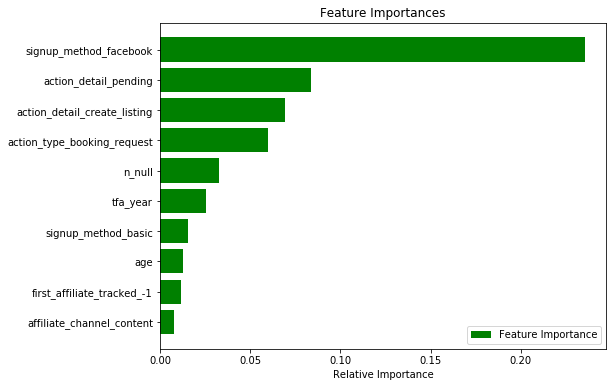

{0: 'signup_method_facebook',
 1: 'action_detail_pending',
 2: 'action_detail_create_listing',
 3: 'action_type_booking_request',
 4: 'n_null',
 5: 'tfa_year',
 6: 'signup_method_basic',
 7: 'age',
 8: 'first_affiliate_tracked_-1',
 9: 'affiliate_channel_content'}

In [0]:
# Get Important Features 
from Data_Preparation_Airbnb import Get_Imp_Features
Imp_Features = Get_Imp_Features(Model=clf, Top=10, Want_to_load=False)
Imp_Features_dict = { i : Imp_Features[i] for i in range(0, len(Imp_Features) ) }
Imp_Features_dict

# 6.  XG-Boost with Early Stopping Method

In [0]:
# XG-Boost trained by using Early Stopping in Kaggle_Submission file
xgb=in_dict["Best_Model"]["xgb2_best_8000"] # load pre-trained model

# prediction and evaluation
print("XG-Boost with Early Stopping")
y_pred = xgb.predict_proba(X_test)
xgboost_score=ndcg_score(y_test, y_pred, k=5)
print("The Test score is:",np.round(xgboost_score,5))

XG-Boost with Early Stopping
The Test score is: 0.8385


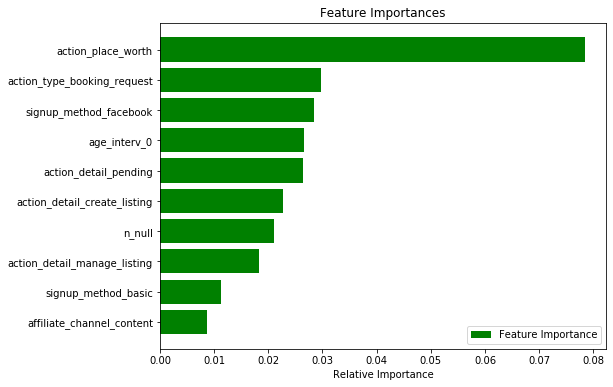

{0: 'action_place_worth',
 1: 'action_type_booking_request',
 2: 'signup_method_facebook',
 3: 'age_interv_0',
 4: 'action_detail_pending',
 5: 'action_detail_create_listing',
 6: 'n_null',
 7: 'action_detail_manage_listing',
 8: 'signup_method_basic',
 9: 'affiliate_channel_content'}

In [0]:
# Get Important Features 
from Data_Preparation_Airbnb import Get_Imp_Features
Imp_Features = Get_Imp_Features(Model=xgb, Top=10, Want_to_load=False)
Imp_Features_dict = { i : Imp_Features[i] for i in range(0, len(Imp_Features) ) }
Imp_Features_dict

## Performance Plot

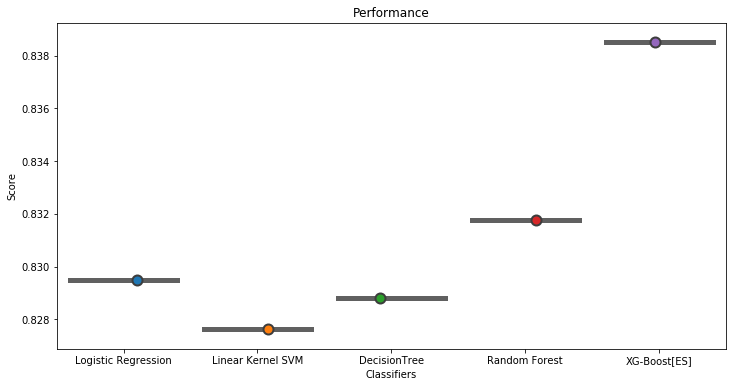

In [0]:
# https://seaborn.pydata.org/generated/seaborn.stripplot.html
# Performance info entries
entries=[]
entries.append(["Logistic Regression",0.8295])
entries.append(["Linear Kernel SVM",0.82763])
entries.append(["DecisionTree",0.8288])
entries.append(["Random Forest",0.83175])
entries.append(["XG-Boost[ES]",0.8385])

# Create dataframe
result_frame = pd.DataFrame(entries, columns=["Classifiers", "Score"])

# ploting Box-strip plot
plt.figure(figsize=(12,6))
plt.title("Performance")
sns.boxplot(x='Classifiers', y='Score', data=result_frame, linewidth=5, palette="coolwarm")
sns.stripplot(x='Classifiers', y='Score', data=result_frame, size=10, edgecolor="gray", linewidth=2)
plt.show()

<h2>Observation:</h2>

* Signup_method by Facebook, Age, Place_worth are the most important features that influence Destination  

* Normalized discounted cumulative gain Metric only depend on Target probability order for prediction.

* Feature selection and hyperparameter tunning helped to improve performance.

* The Xg-Boost classifier with early stopping outperform with NDCG_Score of 0.8385.